<a href="https://colab.research.google.com/github/Ziad-El3assal/Roll_Pitch_Yaw-Detection/blob/main/Roll_Pitch_Yaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


### Installing MediaPipe

In [3]:
%%capture
!pip install mediapipe

### Required Libraries

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### Dowlining Data

In [6]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [7]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [8]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

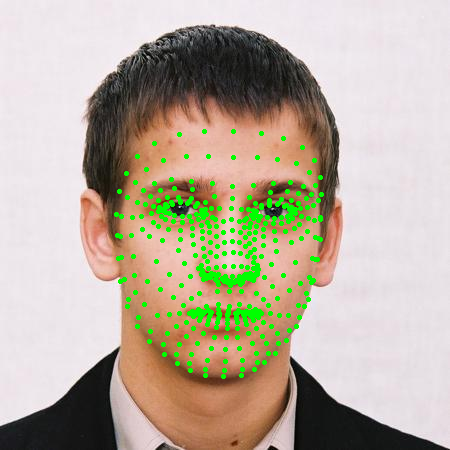

In [9]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

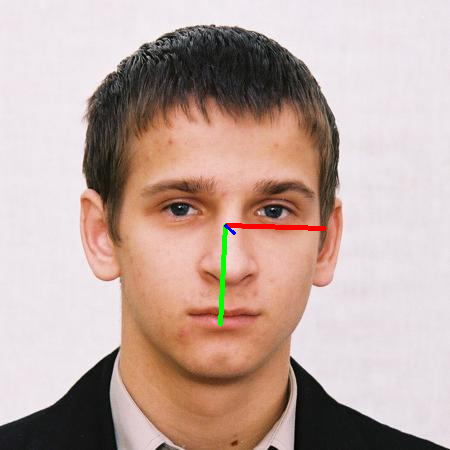

In [10]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [11]:
from ast import IfExp
data=[]
labels=[]
has_blobs=[]
for i in os.listdir('/content/AFLW2000'):
  cur=[]
  if 'jpg' in i:
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread('/content/AFLW2000/'+i)
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  cur.append([relative_x,relative_y])
        if len(cur)!=0:
          data.append(cur)
          has_blobs.append(i[:-4])




In [12]:
labels=[]
for i in os.listdir('/content/AFLW2000'):
  if 'mat' in i and (i[:-4] in has_blobs) :
    mat_file = sio.loadmat('/content/AFLW2000/'+i)
    # extracting the labels 3 angels
    pose_para = mat_file["Pose_Para"][0][:3]
    pitch = pose_para[0]
    yaw = pose_para[1]
    roll = pose_para[2]
    labels.append([pitch,yaw,roll])

In [13]:
print(len(data))
print(len(labels))

1853
1853


In [14]:
data=np.array(data)
labels=np.array(labels)

In [15]:
data.shape

(1853, 468, 2)

In [16]:
data=data.reshape(data.shape[0],-1)

In [17]:
data.shape

(1853, 936)

In [18]:
labels.shape

(1853, 3)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x = data[:, :468]
y = data[:, 468:]

# Normalize x
data_norm = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))

# Normalize y
label_norm = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))

print("Normalized x shape:", data_norm.shape)
print("Normalized y shape:", label_norm.shape)

data = np.hstack((data_norm, label_norm))

print("Reconstructed features shape:", data.shape)

Normalized x shape: (1853, 468)
Normalized y shape: (1853, 468)
Reconstructed features shape: (1853, 936)


In [21]:
X_train,x_test,Y_train,y_test =train_test_split(data,labels,train_size=0.8,shuffle=True)
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,train_size=0.8,shuffle=True)

## XGBoost

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import cv2

In [23]:
def get_blobs(image):
  X,Y=[],[]
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None:
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                X.append(x)
                Y.append(y)
        X=np.array(X)
        Y=np.array(Y)
  try :
    x_normalized = ((X - np.min(X)) / (np.max(X) - np.min(X)))
    y_normalized = ((Y - np.min(Y )) / (np.max(Y ) - np.min(Y )))
    poses = np.hstack((x_normalized, y_normalized)).reshape((1, -1))
    tdx = shape[1] * X[168]
    tdy = shape[0] * Y[168]
    return poses,tdx,tdy
  except:
    return np.array([[]]),0,0

In [24]:
def pred(model,image):
  blobs,tdx,tdy=get_blobs(image)
  pitch,yaw,roll=model.predict(blobs)[0]

  return pitch,yaw,roll,tdx,tdy

In [25]:
def run_on_image(model,path):
  image = cv2.imread(path)
  pitch ,yaw ,roll ,tdx,tdy=pred(model,image)
  cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx,tdy))

In [26]:
def save_run_vidoe(in_path,out_path,model):
  video_capture = cv2.VideoCapture(in_path)
  fps = int(video_capture.get(cv2.CAP_PROP_FPS))
  width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  video_writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
  pitch,yaw,roll=0,0,0
  while True:
      ret, frame = video_capture.read()
      if not ret:
          break
      b,tdx,tdy=get_blobs(frame)

      if b.shape[1]==0:
        continue
      pitch,yaw,roll=model.predict(b)[0]
      video_writer.write(draw_axis(frame,pitch,yaw,roll,tdx,tdy))
      if cv2.waitKey(25) & 0xFF == ord('q'):
          break

  video_capture.release()
  video_writer.release()
  cv2.destroyAllWindows()

In [66]:
def three_model_pred_image(m1,m2,m3,path):
  img=cv2.imread(path)
  b,tdx,tdy=get_blobs(img)
  pitch=m1.predict(b)[0]
  yaw=m2.predict(b)[0]
  roll=m3.predict(b)[0]
  cv2_imshow(draw_axis(image,pitch,yaw,roll,tdx,tdy))

In [68]:
def three_model_pred_video(m1,m2,m3,in_path,out_path):
  video_capture = cv2.VideoCapture(in_path)
  fps = int(video_capture.get(cv2.CAP_PROP_FPS))
  width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  video_writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
  pitch,yaw,roll=0,0,0
  while True:
      ret, frame = video_capture.read()
      if not ret:
          break
      b,tdx,tdy=get_blobs(frame)

      if b.shape[1]==0:
        continue
      pitch,yaw,roll=m1.predict(b)[0],m2.predict(b)[0],m3.predict(b)[0]
      video_writer.write(draw_axis(frame,pitch,yaw,roll,tdx,tdy))
      if cv2.waitKey(25) & 0xFF == ord('q'):
          break

  video_capture.release()
  video_writer.release()
  cv2.destroyAllWindows()

In [27]:
x_train.shape

(1185, 936)

In [28]:
xgb= XGBRegressor()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(xgb, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.579053
Mean cross-validation score: -0.32


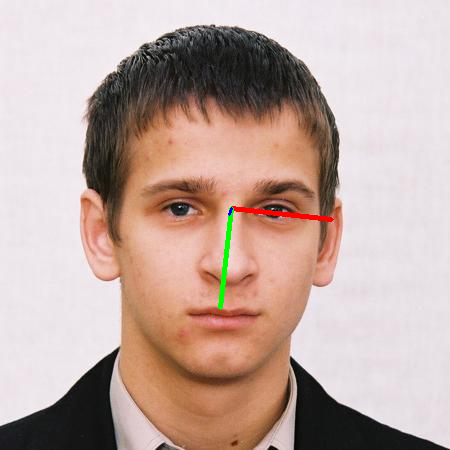

In [29]:
run_on_image(xgb,'/content/AFLW2000/'+random_file+'.jpg')

In [30]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/xgb_1.mp4',xgb)

## Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression


## With no regularization

In [32]:
lr= LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(lr, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 1.342557
Mean cross-validation score: -0.74


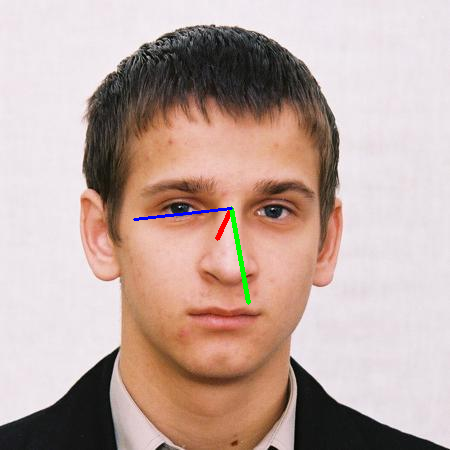

In [33]:
run_on_image(lr,'/content/AFLW2000/'+random_file+'.jpg')

In [34]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/lr_1.mp4',lr)

### LASO

In [35]:
from sklearn.linear_model import Lasso


In [36]:
ls= Lasso()
ls.fit(x_train, y_train)
y_pred = ls.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(ls, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.395986
Mean cross-validation score: -0.01


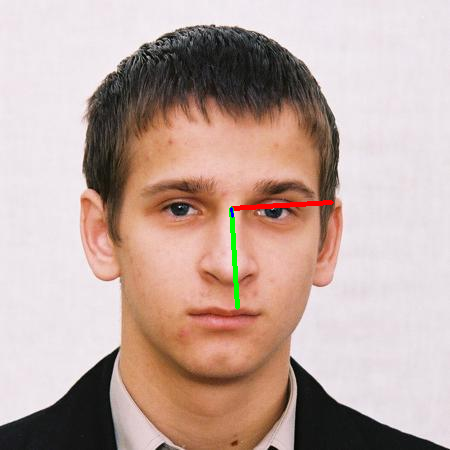

In [37]:
run_on_image(ls,'/content/AFLW2000/'+random_file+'.jpg')

In [38]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/lasso_1.mp4',ls)

In [39]:
from sklearn.linear_model import Ridge


### Ridge

In [40]:
Rd= Ridge()
Rd.fit(x_train, y_train)
y_pred = Rd.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(Rd, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.397217
Mean cross-validation score: -0.08


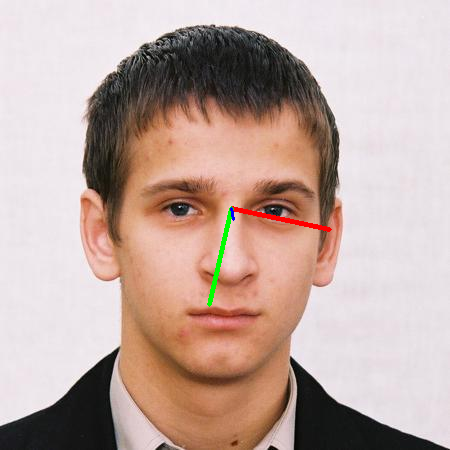

In [41]:
run_on_image(Rd,'/content/AFLW2000/'+random_file+'.jpg')

In [42]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/ridge_1.mp4',Rd)

## ElasticNet

In [43]:
from sklearn.linear_model import ElasticNet


In [44]:
en= ElasticNet()
en.fit(x_train, y_train)
y_pred = en.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(en, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.395986
Mean cross-validation score: -0.01


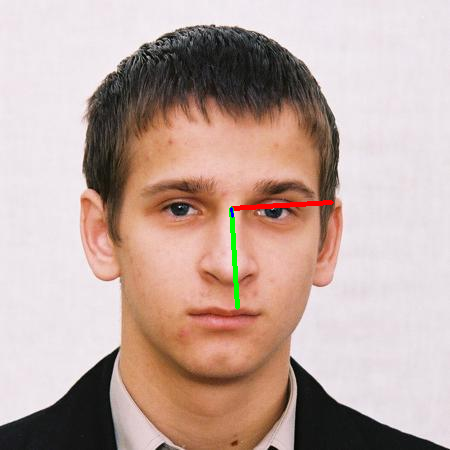

In [45]:
run_on_image(en,'/content/AFLW2000/'+random_file+'.jpg')

In [46]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/elasticN_1.mp4',en)

## SVM

In [47]:
from sklearn.ensemble import RandomForestRegressor


In [48]:
rfr= RandomForestRegressor()
rfr.fit(x_train, y_train)
y_pred = rfr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(rfr, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.464200
Mean cross-validation score: -0.14


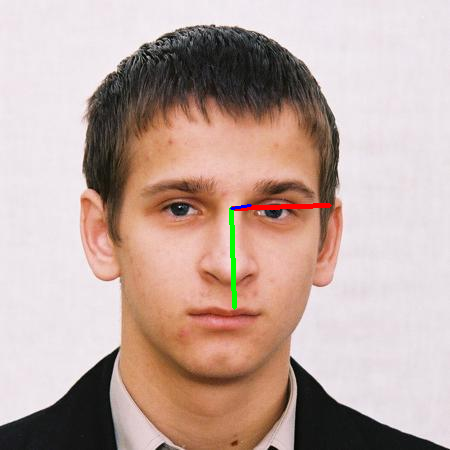

In [49]:
run_on_image(rfr,'/content/AFLW2000/'+random_file+'.jpg')

In [50]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/rfr_1.mp4',rfr)

## KNN


In [51]:
from sklearn.neighbors import KNeighborsRegressor


In [52]:
knn= KNeighborsRegressor(n_neighbors=6)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(knn, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.474939
Mean cross-validation score: -0.20


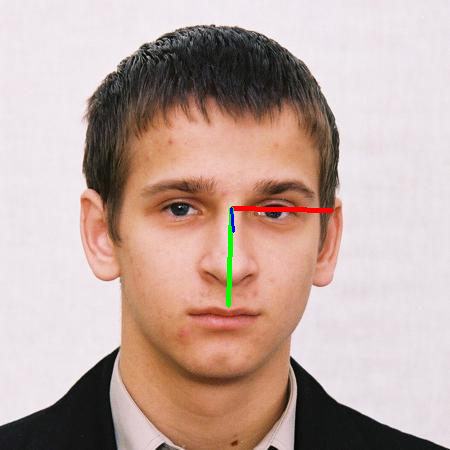

In [53]:
run_on_image(knn,'/content/AFLW2000/'+random_file+'.jpg')

In [54]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/knn_1.mp4',knn)

## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor


In [56]:
dtr= DecisionTreeRegressor()
dtr.fit(x_train, y_train)
y_pred = dtr.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
scores = cross_val_score(dtr, x_val, y_val, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

RMSE: 0.605653
Mean cross-validation score: -0.98


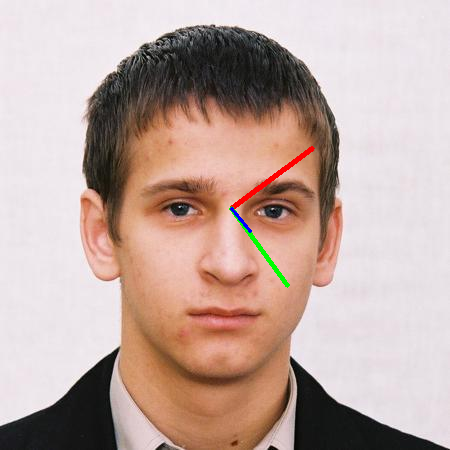

In [57]:
run_on_image(dtr,'/content/AFLW2000/'+random_file+'.jpg')

In [58]:
#save_run_vidoe('/content/videoplayback.mp4','/content/drive/MyDrive/dtr_1.mp4',dtr)

## AdaBoost

In [62]:
from sklearn.ensemble import AdaBoostRegressor
adaboost_pitch = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), n_estimators=100, random_state=42)
adaboost_yaw = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), n_estimators=100, random_state=42)
adaboost_roll = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), n_estimators=100, random_state=42)


pitch=y_train[:,0]
yaw=y_train[:,1]
roll=y_train[:,2]
adaboost_pitch.fit(x_train,pitch)
adaboost_yaw.fit(x_train,yaw)
adaboost_roll.fit(x_train,roll)


y_pred_pitch = adaboost_pitch.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test[:,0], y_pred_pitch))
print("Pitch error : %f",rmse)

y_pred_yaw = adaboost_yaw.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test[:,1], y_pred_yaw))
print("yaw error : %f",rmse)


y_pred_roll = adaboost_roll.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test[:,2], y_pred_roll))
print("roll error : %f",rmse)



Pitch error : %f 0.4137605711608926
yaw error : %f 0.7242960854369798
roll error : %f 1.2914834626803018


In [63]:
y_pred=np.c_[y_pred_pitch,y_pred_yaw,y_pred_roll]
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.887643


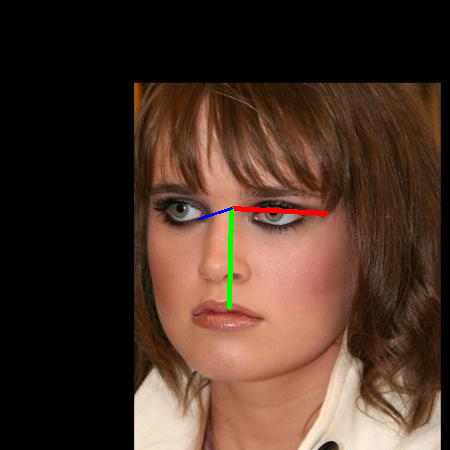

In [67]:
three_model_pred_image(adaboost_pitch,adaboost_yaw,adaboost_roll,'/content/AFLW2000/'+random_file+'.jpg')

In [78]:
three_model_pred_video(adaboost_pitch,adaboost_yaw,adaboost_roll,'/content/videoplayback.mp4','/content/drive/MyDrive/adaboost_1.mp4')

## SVM

In [70]:
from sklearn.svm import SVR


In [71]:
svr_pitch=SVR(kernel='rbf',gamma=0.5,epsilon=0.2)
svr_yaw=SVR(kernel='rbf',gamma=0.5,epsilon=0.2)
svr_roll=SVR(kernel='rbf',gamma=0.5,epsilon=0.2)

pitch=y_train[:,0]
yaw=y_train[:,1]
roll=y_train[:,2]


svr_pitch.fit(x_train,pitch)
svr_yaw.fit(x_train,yaw)
svr_roll.fit(x_train,roll)

pitch=y_train[:,0]
yaw=y_train[:,1]
roll=y_train[:,2]

y_pred_pitch = svr_pitch.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test[:,0], y_pred_pitch))
print("Pitch error : %f",rmse)

y_pred_yaw = svr_yaw.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test[:,1], y_pred_yaw))
print("yaw error : %f",rmse)


y_pred_roll = svr_roll.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test[:,2], y_pred_roll))
print("roll error : %f",rmse)

Pitch error : %f 0.28074034040166745
yaw error : %f 0.5657777487846957
roll error : %f 0.3263622235716637


In [72]:
y_pred=np.c_[y_pred_pitch,y_pred_yaw,y_pred_roll]
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.410460


In [75]:
y_pred.shape

(371, 3)

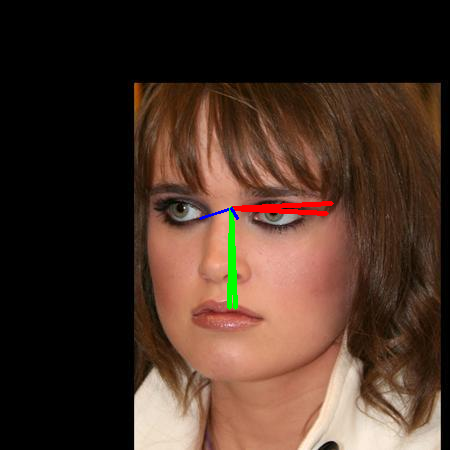

In [74]:
three_model_pred_image(svr_pitch,svr_yaw,svr_roll,'/content/AFLW2000/'+random_file+'.jpg')

In [77]:
three_model_pred_video(svr_pitch,svr_yaw,svr_roll,'/content/videoplayback.mp4','/content/drive/MyDrive/svr_1.mp4')

## Grid Search for the best hyper parameters of AdaBoost

In [79]:
# prompt: generate code for grid search for hyperparameters of AdaBoost models in the cell above

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for each model
param_grid_pitch = {
    'base_estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1]
}

param_grid_yaw = {
    'base_estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1]
}

param_grid_roll = {
    'base_estimator__max_depth': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1]
}

# Create the GridSearchCV objects
grid_search_pitch = GridSearchCV(adaboost_pitch, param_grid_pitch, cv=5)
grid_search_yaw = GridSearchCV(adaboost_yaw, param_grid_yaw, cv=5)
grid_search_roll = GridSearchCV(adaboost_roll, param_grid_roll, cv=5)

# Fit the models
grid_search_pitch.fit(x_train, y_train[:, 0])
grid_search_yaw.fit(x_train, y_train[:, 1])
grid_search_roll.fit(x_train, y_train[:, 2])

# Print the best parameters for each model
print("Best parameters for pitch model:", grid_search_pitch.best_params_)
print("Best parameters for yaw model:", grid_search_yaw.best_params_)
print("Best parameters for roll model:", grid_search_roll.best_params_)

# Use the best models to make predictions
y_pred_pitch = grid_search_pitch.predict(x_test)
y_pred_yaw = grid_search_yaw.predict(x_test)
y_pred_roll = grid_search_roll.predict(x_test)

# Evaluate the predictions
rmse_pitch = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_pitch))
rmse_yaw = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_yaw))
rmse_roll = np.sqrt(mean_squared_error(y_test[:, 2], y_pred_roll))

print("Pitch RMSE:", rmse_pitch)
print("Yaw RMSE:", rmse_yaw)
print("Roll RMSE:", rmse_roll)


Best parameters for pitch model: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Best parameters for yaw model: {'base_estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 100}
Best parameters for roll model: {'base_estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 50}
Pitch RMSE: 0.26653782344332294
Yaw RMSE: 0.5446811430001224
Roll RMSE: 0.31982777472505364


In [92]:
y_pred=np.c_[y_pred_pitch,y_pred_yaw,y_pred_roll]
np.sqrt(mean_squared_error(y_test, y_pred))

0.3958155144135558

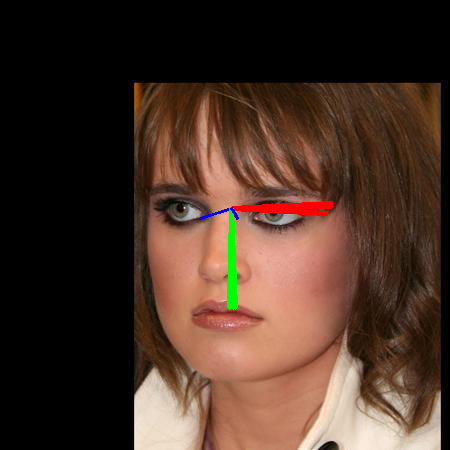

In [90]:
three_model_pred_image(grid_search_pitch,grid_search_yaw,grid_search_roll,'/content/AFLW2000/'+random_file+'.jpg')

In [91]:
three_model_pred_video(grid_search_pitch,grid_search_yaw,grid_search_roll,'/content/videoplayback.mp4','/content/drive/MyDrive/gs.mp4')

In [89]:

import joblib

# Save the models to pickle files
with open('/content/drive/MyDrive/mmodels/xgb.pkl', 'wb') as f:
    joblib.dump(xgb, f)

with open('/content/drive/MyDrive/mmodels/lr.pkl', 'wb') as f:
    joblib.dump(lr, f)

with open('/content/drive/MyDrive/mmodels/ls.pkl', 'wb') as f:
    joblib.dump(ls, f)

# with open('/content/drive/MyDrive/mmodels/models/Rd.pkl', 'wb') as f:
#     joblib.dump(Rd, f)

with open('/content/drive/MyDrive/mmodels/en.pkl', 'wb') as f:
    joblib.dump(en, f)

with open('/content/drive/MyDrive/mmodels/rfr.pkl', 'wb') as f:
    joblib.dump(rfr, f)

with open('/content/drive/MyDrive/mmodels/knn.pkl', 'wb') as f:
    joblib.dump(knn, f)

with open('/content/drive/MyDrive/mmodels/dtr.pkl', 'wb') as f:
    joblib.dump(dtr, f)

with open('/content/drive/MyDrive/mmodels/adaboost.pkl', 'wb') as f:
    joblib.dump(adaboost_pitch, f)

with open('/content/drive/MyDrive/mmodels/svr_pitch.pkl', 'wb') as f:
    joblib.dump(svr_pitch, f)

with open('/content/drive/MyDrive/mmodels/svr_yaw.pkl', 'wb') as f:
    joblib.dump(svr_yaw, f)

with open('/content/drive/MyDrive/mmodels/svr_roll.pkl', 'wb') as f:
    joblib.dump(svr_roll, f)

with open('/content/drive/MyDrive/mmodels/grid_search_pitch.pkl', 'wb') as f:
    joblib.dump(grid_search_pitch, f)

with open('/content/drive/MyDrive/mmodels/grid_search_yaw.pkl', 'wb') as f:
    joblib.dump(grid_search_yaw, f)

with open('/content/drive/MyDrive/mmodels/grid_search_roll.pkl', 'wb') as f:
    joblib.dump(grid_search_roll, f)